<a href="https://colab.research.google.com/github/bradleyboehmke/uc-bana-4080/blob/main/example-notebooks/03_jupyter_notebook_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
# Install kagglehub if not already installed
try:
    import kagglehub
except:
    print("Installing kagglehub...")
    import sys
    !{sys.executable} -m pip install kagglehub -q

# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report)

warnings.filterwarnings('ignore')
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [3]:
class CGMFeatureExtractor:
    def __init__(self, window_size=15, delta_t=5):
        self.window_size = window_size
        self.delta_t = delta_t

    def extract_features(self, bg_window):
        features = {}
        features['bg_mean'] = np.mean(bg_window)
        features['bg_std'] = np.std(bg_window)
        features['bg_min'] = np.min(bg_window)
        features['bg_max'] = np.max(bg_window)
        features['bg_range'] = features['bg_max'] - features['bg_min']
        features['bg_overall_change'] = bg_window[-1] - bg_window[0]
        features['bg_velocity'] = features['bg_overall_change'] / (14 * self.delta_t)

        dp = np.diff(bg_window)
        features['bg_dp_mean'] = np.mean(dp)
        features['bg_dp_std'] = np.std(dp)
        features['bg_dp_max'] = np.max(dp)
        features['bg_dp_min'] = np.min(dp)

        vp = dp / self.delta_t
        features['bg_vp_mean'] = np.mean(vp)
        features['bg_vp_std'] = np.std(vp)
        features['bg_vp_max'] = np.max(vp)
        features['bg_vp_min'] = np.min(vp)

        if len(bg_window) >= 3:
            ap = (bg_window[2:] - bg_window[:-2]) / ((2 * self.delta_t) ** 2)
            features['bg_ap_mean'] = np.mean(ap)
            features['bg_ap_std'] = np.std(ap)
            features['bg_ap_max'] = np.max(ap)
            features['bg_ap_min'] = np.min(ap)

        features['bg_increasing_count'] = np.sum(dp > 0)
        features['bg_decreasing_count'] = np.sum(dp < 0)
        features['bg_stable_count'] = np.sum(np.abs(dp) < 5)

        return features

class HRFeatureExtractor:
    def extract_features(self, hr_window):
        features = {}
        features['hr_mean'] = np.mean(hr_window)
        features['hr_std'] = np.std(hr_window)
        features['hr_min'] = np.min(hr_window)
        features['hr_max'] = np.max(hr_window)
        features['hr_range'] = features['hr_max'] - features['hr_min']
        features['hr_cv'] = features['hr_std'] / features['hr_mean'] if features['hr_mean'] > 0 else 0

        hrp = np.diff(hr_window)
        features['hr_hrp_mean'] = np.mean(hrp)
        features['hr_hrp_std'] = np.std(hrp)
        features['hr_hrp_max'] = np.max(hrp)
        features['hr_hrp_min'] = np.min(hrp)
        features['hr_increasing_count'] = np.sum(hrp > 0)
        features['hr_decreasing_count'] = np.sum(hrp < 0)
        features['hr_25percentile'] = np.percentile(hr_window, 25)
        features['hr_75percentile'] = np.percentile(hr_window, 75)
        features['hr_median'] = np.median(hr_window)

        return features

In [4]:
def generate_synthetic_data(n_samples=2000):
    print("  Generating synthetic data...")
    timestamps = pd.date_range(start='2024-01-01', periods=n_samples, freq='5min')
    glucose_base = 120 + 20 * np.sin(np.arange(n_samples) * 2 * np.pi / 288)
    glucose = glucose_base + np.random.normal(0, 10, n_samples)
    hr_base = 75 + 10 * np.sin(np.arange(n_samples) * 2 * np.pi / 288)
    heart_rate = hr_base + np.random.normal(0, 5, n_samples)
    activity = np.random.choice([0, 1], size=n_samples, p=[0.85, 0.15])

    for idx in np.where(activity == 1)[0]:
        end_idx = min(idx + 10, n_samples)
        glucose[idx:end_idx] -= np.random.uniform(10, 30)
        heart_rate[idx:end_idx] += np.random.uniform(20, 50)

    glucose = np.clip(glucose, 40, 400)
    heart_rate = np.clip(heart_rate, 50, 200)

    return pd.DataFrame({
        'timestamp': timestamps,
        'glucose': glucose,
        'heart_rate': heart_rate,
        'activity': activity
    })

def load_ohio_t1dm_data(path):
    import xml.etree.ElementTree as ET
    print(f"\nLoading OhioT1DM dataset from: {path}")
    all_data = []

    patient_folders = []
    for root, dirs, files in os.walk(path):
        if any(f.endswith('.xml') or f.endswith('.csv') for f in files):
            patient_folders.append(root)

    print(f"Found {len(patient_folders)} patient folders")

    for folder in patient_folders:
        patient_id = os.path.basename(folder)
        print(f"  Processing: {patient_id}", end='')

        csv_files = glob.glob(os.path.join(folder, '*.csv'))
        xml_files = glob.glob(os.path.join(folder, '*.xml'))

        if csv_files:
            for csv_file in csv_files:
                try:
                    data = pd.read_csv(csv_file)
                    if any(col in data.columns for col in ['glucose', 'glucose_level', 'CGM', 'bg']):
                        for old, new in [('glucose_level', 'glucose'), ('CGM', 'glucose'), ('bg', 'glucose')]:
                            if old in data.columns:
                                data.rename(columns={old: 'glucose'}, inplace=True)
                                break
                        if 'timestamp' not in data.columns and 'ts' in data.columns:
                            data['timestamp'] = pd.to_datetime(data['ts'])
                        data['patient_id'] = patient_id
                        all_data.append(data)
                        print(f" ✓ ({len(data)} records)")
                        break
                except:
                    continue

        elif xml_files:
            cgm_data, exercise_data, hr_data = [], [], []
            for xml_file in xml_files:
                try:
                    tree = ET.parse(xml_file)
                    root = tree.getroot()
                    fname = os.path.basename(xml_file).lower()

                    if 'cgm' in fname or 'glucose' in fname:
                        for event in root.findall('.//event'):
                            ts, val = event.get('ts'), event.get('value')
                            if ts and val:
                                cgm_data.append({'timestamp': pd.to_datetime(ts), 'glucose': float(val)})

                    elif 'exercise' in fname or 'activity' in fname:
                        for event in root.findall('.//event'):
                            ts = event.get('ts')
                            dur = event.get('duration')
                            if ts:
                                exercise_data.append({'timestamp': pd.to_datetime(ts), 'duration': float(dur) if dur else 30})

                    elif 'hr' in fname or 'heart' in fname:
                        for event in root.findall('.//event'):
                            ts, val = event.get('ts'), event.get('value')
                            if ts and val:
                                hr_data.append({'timestamp': pd.to_datetime(ts), 'heart_rate': float(val)})
                except:
                    continue

            if cgm_data:
                df_cgm = pd.DataFrame(cgm_data)
                df_cgm['patient_id'] = patient_id

                if hr_data:
                    df_hr = pd.DataFrame(hr_data)
                    df_cgm = pd.merge_asof(df_cgm.sort_values('timestamp'),
                                          df_hr.sort_values('timestamp'),
                                          on='timestamp', direction='nearest',
                                          tolerance=pd.Timedelta('10min'))

                df_cgm['activity'] = 0
                for ex in exercise_data:
                    start = ex['timestamp']
                    end = start + pd.Timedelta(minutes=ex.get('duration', 30))
                    df_cgm.loc[(df_cgm['timestamp'] >= start) & (df_cgm['timestamp'] <= end), 'activity'] = 1

                all_data.append(df_cgm)
                print(f" ✓ ({len(df_cgm)} records)")

    if not all_data:
        print("\nNo data found. Using synthetic data.")
        return generate_synthetic_data(2000)

    combined = pd.concat(all_data, ignore_index=True)

    if 'heart_rate' not in combined.columns:
        print("  Generating synthetic HR data...")
        combined['heart_rate'] = np.where(combined.get('activity', 0) == 1,
                                         np.random.uniform(100, 160, len(combined)),
                                         np.random.uniform(60, 90, len(combined)))

    if 'activity' not in combined.columns:
        combined['activity'] = 0

    combined = combined.sort_values('timestamp').reset_index(drop=True)
    result = combined[['timestamp', 'glucose', 'heart_rate', 'activity']].copy()

    print(f"\nDataset Summary:")
    print(f"  Total samples: {len(result)}")
    print(f"  Activity: {result['activity'].sum()} ({result['activity'].mean()*100:.1f}%)")

    return result

In [5]:
class ActivityDetectionPipeline:
    def __init__(self, window_size=15, delta_t=5):
        self.window_size = window_size
        self.delta_t = delta_t
        self.cgm_extractor = CGMFeatureExtractor(window_size, delta_t)
        self.hr_extractor = HRFeatureExtractor()
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}

    def preprocess_data(self, df):
        df = df.copy()
        for col in ['glucose', 'heart_rate']:
            if df[col].isnull().any():
                df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        return df.dropna()

    def create_sliding_windows(self, df):
        features_list, labels_list = [], []
        df = df.sort_values('timestamp').reset_index(drop=True)

        print(f"  Creating sliding windows (size={self.window_size})...")
        for i in range(len(df) - self.window_size + 1):
            if i % 500 == 0:
                print(f"    {i}/{len(df)-self.window_size+1}", end='\r')

            window = df.iloc[i:i+self.window_size]
            cgm_feats = self.cgm_extractor.extract_features(window['glucose'].values)
            hr_feats = self.hr_extractor.extract_features(window['heart_rate'].values)
            features_list.append({**cgm_feats, **hr_feats})
            labels_list.append(window['activity'].iloc[-1])

        print(f"    {len(features_list)}/{len(df)-self.window_size+1} ✓")
        return pd.DataFrame(features_list), np.array(labels_list)

    def initialize_models(self):
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
            'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
            'SVM (Poly)': SVC(kernel='poly', degree=3, probability=True, random_state=42),
            'SVM (Sigmoid)': SVC(kernel='sigmoid', probability=True, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
            'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
            'Gaussian NB': GaussianNB()
        }

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print("\n" + "="*80)
        print("TRAINING MODELS")
        print("="*80)

        for name, model in self.models.items():
            print(f"  {name}...", end=' ')
            try:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

                self.results[name] = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, zero_division=0),
                    'recall': recall_score(y_test, y_pred, zero_division=0),
                    'f1_score': f1_score(y_test, y_pred, zero_division=0),
                    'auc': roc_auc_score(y_test, y_prob) if y_prob is not None else 0,
                    'confusion_matrix': confusion_matrix(y_test, y_pred),
                    'probabilities': y_prob
                }

                cv = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
                self.results[name]['cv_mean'] = cv.mean()
                self.results[name]['cv_std'] = cv.std()

                print(f"✓ F1={self.results[name]['f1_score']:.3f}")
            except Exception as e:
                print(f"✗ {e}")

        print("="*80)
        return self.results, y_test

    def plot_results(self, y_test):
        print("\nGenerating plots...")

        # Performance comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[idx//2, idx%2]
            models = list(self.results.keys())
            values = [self.results[m][metric] for m in models]
            bars = ax.barh(range(len(models)), values, color='steelblue', alpha=0.7)
            ax.set_yticks(range(len(models)))
            ax.set_yticklabels(models, fontsize=9)
            ax.set_xlabel(title, fontsize=11, fontweight='bold')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlim([0, 1.1])
            ax.grid(axis='x', alpha=0.3)
            for bar, val in zip(bars, values):
                ax.text(val+0.02, bar.get_y()+bar.get_height()/2, f'{val:.3f}', va='center', fontsize=8)

        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        print("  ✓ performance_comparison.png")
        plt.show()

        # ROC curves
        plt.figure(figsize=(10, 7))
        for name, res in self.results.items():
            if res['probabilities'] is not None:
                fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
                plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})", linewidth=2)
        plt.plot([0,1], [0,1], 'k--', label='Random', linewidth=2)
        plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        plt.title('ROC Curves', fontsize=14, fontweight='bold')
        plt.legend(fontsize=9)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        print("  ✓ roc_curves.png")
        plt.show()

        # Top 3 confusion matrices
        top3 = sorted(self.results.items(), key=lambda x: x[1]['f1_score'], reverse=True)[:3]
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        for idx, (name, res) in enumerate(top3):
            sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['No Activity', 'Activity'],
                       yticklabels=['No Activity', 'Activity'])
            axes[idx].set_title(f'{name}\nF1={res["f1_score"]:.3f}', fontsize=11, fontweight='bold')
            axes[idx].set_ylabel('True', fontsize=10)
            axes[idx].set_xlabel('Predicted', fontsize=10)
        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        print("  ✓ confusion_matrices.png")
        plt.show()

        print("\n✓ All plots saved!")

    def generate_report(self):
        print("\n" + "="*80)
        print("PERFORMANCE REPORT")
        print("="*80)

        data = []
        for name, metrics in self.results.items():
            data.append({
                'Model': name,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1_score'],
                'AUC': metrics['auc'],
                'CV Mean': metrics['cv_mean'],
                'CV Std': metrics['cv_std']
            })

        df = pd.DataFrame(data).sort_values('F1-Score', ascending=False).reset_index(drop=True)
        print("\n" + df.to_string(index=False))

        print("\n" + "-"*80)
        print("BEST MODEL:")
        best = df.iloc[0]
        print(f"  {best['Model']}")
        print(f"  Accuracy:  {best['Accuracy']:.4f}")
        print(f"  Precision: {best['Precision']:.4f}")
        print(f"  Recall:    {best['Recall']:.4f}")
        print(f"  F1-Score:  {best['F1-Score']:.4f}")
        print(f"  AUC:       {best['AUC']:.4f}")
        print("="*80)

        df.to_csv('model_results.csv', index=False)
        print("\n✓ Results saved to model_results.csv")
        return df


CS446 PROJECT 6: T1DM PHYSICAL ACTIVITY DETECTION

[1] LOADING DATA
--------------------------------------------------------------------------------


100%|██████████| 2.22M/2.22M [00:00<00:00, 3.64MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/ryanmouton/ohiot1dm/versions/1

Loading OhioT1DM dataset from: /root/.cache/kagglehub/datasets/ryanmouton/ohiot1dm/versions/1
Found 1 patient folders
  Processing: 1
No data found. Using synthetic data.
  Generating synthetic data...

[2] PREPROCESSING
--------------------------------------------------------------------------------
  Samples after preprocessing: 2000

[3] FEATURE EXTRACTION
--------------------------------------------------------------------------------
  Creating sliding windows (size=15)...
    1986/1986 ✓
  Feature matrix: (1986, 37)
  Features: 37

[4] TRAIN/TEST SPLIT
--------------------------------------------------------------------------------
  Training: 1588 samples
  Testing:  398 samples
  Activity in train: 244 (15.4%)
  Activity in test:  61 (15.3%)

[5] TRAINING & EVALUATION
--------------------------------------------------------------------------------

TRAINING MODELS
  Logistic Regression... ✓ F1=0.390
 

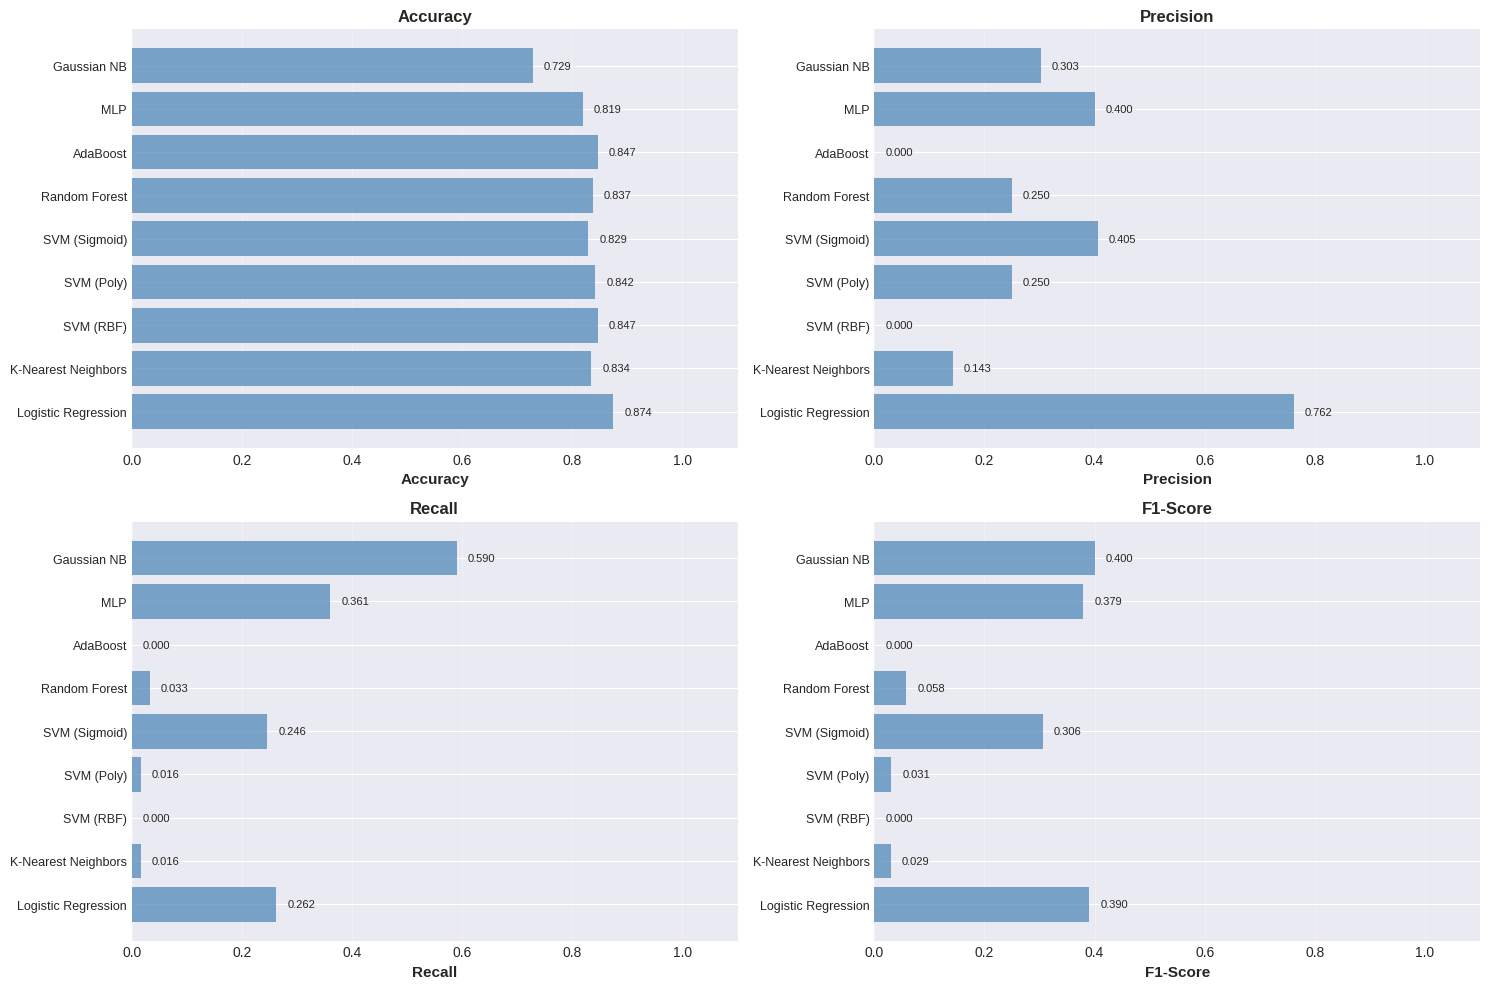

  ✓ roc_curves.png


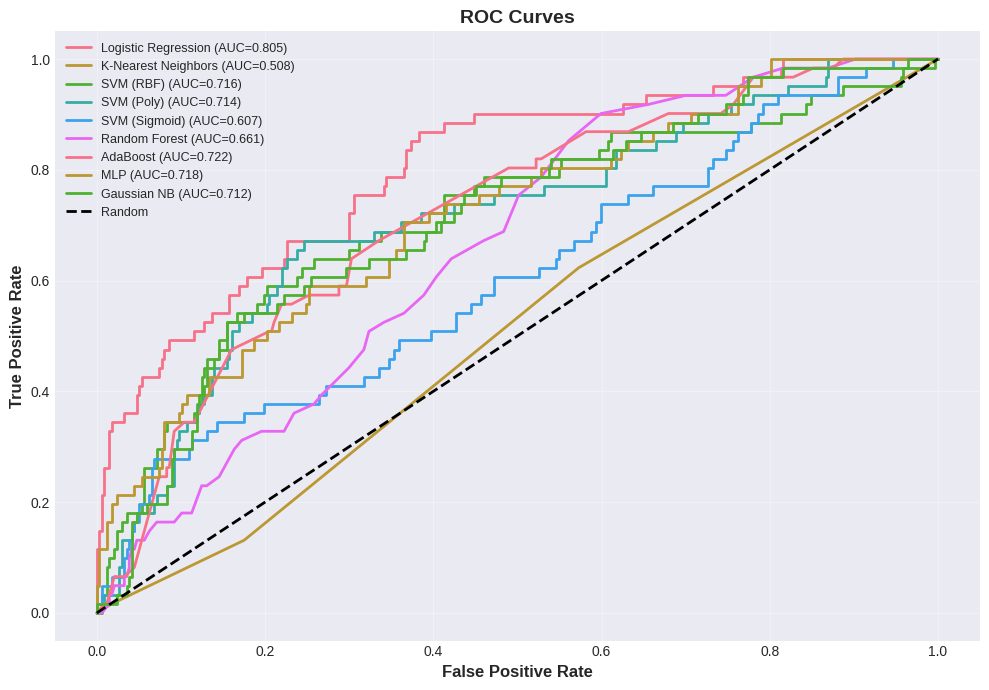

  ✓ confusion_matrices.png


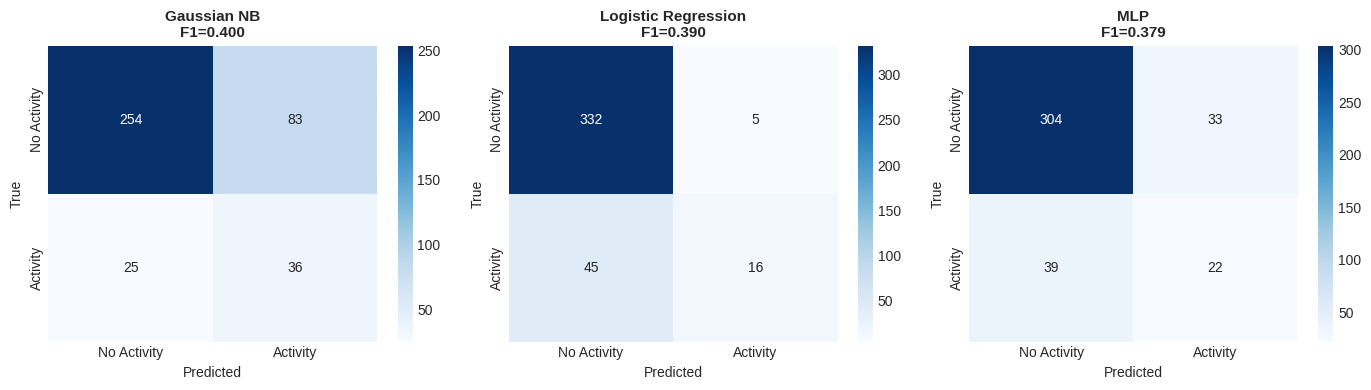


✓ All plots saved!

[7] FINAL REPORT
--------------------------------------------------------------------------------

PERFORMANCE REPORT

              Model  Accuracy  Precision   Recall  F1-Score      AUC  CV Mean   CV Std
        Gaussian NB  0.728643   0.302521 0.590164  0.400000 0.712409 0.322031 0.050128
Logistic Regression  0.874372   0.761905 0.262295  0.390244 0.804641 0.359064 0.073763
                MLP  0.819095   0.400000 0.360656  0.379310 0.718052 0.327264 0.033667
      SVM (Sigmoid)  0.829146   0.405405 0.245902  0.306122 0.606509 0.193998 0.026268
      Random Forest  0.836683   0.250000 0.032787  0.057971 0.660821 0.036109 0.039127
         SVM (Poly)  0.841709   0.250000 0.016393  0.030769 0.714355 0.101592 0.039904
K-Nearest Neighbors  0.834171   0.142857 0.016393  0.029412 0.508416 0.062135 0.049836
          SVM (RBF)  0.846734   0.000000 0.000000  0.000000 0.715961 0.000000 0.000000
           AdaBoost  0.846734   0.000000 0.000000  0.000000 0.721774 0.021333

In [6]:
def main():
    print("\n" + "="*80)
    print("CS446 PROJECT 6: T1DM PHYSICAL ACTIVITY DETECTION")
    print("="*80)

    # 1. Load data
    print("\n[1] LOADING DATA")
    print("-"*80)
    try:
        path = kagglehub.dataset_download("ryanmouton/ohiot1dm")
        print(f"Dataset path: {path}")
        df = load_ohio_t1dm_data(path)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Using synthetic data...")
        df = generate_synthetic_data(2000)

    # 2. Preprocess
    print("\n[2] PREPROCESSING")
    print("-"*80)
    pipeline = ActivityDetectionPipeline(window_size=15, delta_t=5)
    df = pipeline.preprocess_data(df)
    print(f"  Samples after preprocessing: {len(df)}")

    # 3. Feature extraction
    print("\n[3] FEATURE EXTRACTION")
    print("-"*80)
    X, y = pipeline.create_sliding_windows(df)
    print(f"  Feature matrix: {X.shape}")
    print(f"  Features: {X.shape[1]}")

    # 4. Split data
    print("\n[4] TRAIN/TEST SPLIT")
    print("-"*80)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"  Training: {len(X_train)} samples")
    print(f"  Testing:  {len(X_test)} samples")
    print(f"  Activity in train: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
    print(f"  Activity in test:  {y_test.sum()} ({y_test.mean()*100:.1f}%)")

    # 5. Train models
    print("\n[5] TRAINING & EVALUATION")
    print("-"*80)
    pipeline.initialize_models()
    results, y_test = pipeline.train_and_evaluate(X_train, X_test, y_train, y_test)

    # 6. Visualize
    print("\n[6] VISUALIZATION")
    print("-"*80)
    pipeline.plot_results(y_test)

    # 7. Report
    print("\n[7] FINAL REPORT")
    print("-"*80)
    results_df = pipeline.generate_report()

    print("\n" + "="*80)
    print("PROJECT COMPLETE! ✓")
    print("="*80)
    print("\nGenerated files:")
    print("  • performance_comparison.png")
    print("  • roc_curves.png")
    print("  • confusion_matrices.png")
    print("  • model_results.csv")

    return pipeline, results_df

# RUN EVERYTHING
if __name__ == "__main__":
    pipeline, results = main()